In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, re

from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, cross_validate, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, make_scorer

import missingno as msno
from sklearn import set_config
plt.style.use('fivethirtyeight')
cm = sns.color_palette("coolwarm", as_cmap=True)
set_config(display="diagram")

# Contents

* [Introduction](#intro)
* [EDA](#eda)
* [Predictions](#prediction)
    - [base regressors](#based)
    - [tuned regressors](#tuned)
    - [Ensemble of regressors](#ensemble)
* [Conclusion](#ccl)

<a id="intro"></a>
# Introduction & Motivation

`TETR.IO` is a free-to-play online multiplayer and single player game developed by osk. Players can play against friends and foes all over the world and claim a spot on the leaderboards, found in the TETRA CHANNEL.

In this notebook I'll train some regressors to predict the player rank : `TR`.

![Player Rank](https://tetris.wiki/images/4/47/Tetra_League_TR_and_Rank_Information_-_Tetrio.png)

Details can be found in the [wiki](https://tetris.wiki/TETR.IO)


<a id="EDA"></a>
# EDA

In [2]:
df = pd.read_csv('tl-data.csv')

<AxesSubplot:>

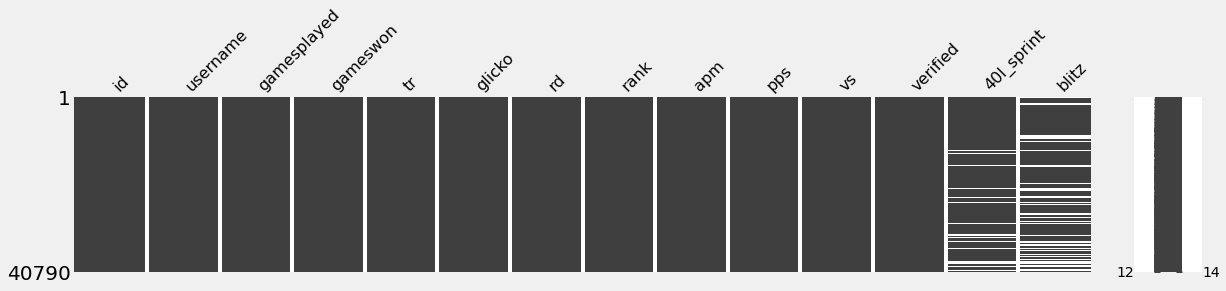

In [3]:
# check missing values
msno.matrix(df, figsize=(18,3))

In [4]:
# feature engineering: replace games played and games won by the respective ratio
df['ratio_won_played'] = df['gameswon'] / df['gamesplayed']

In [5]:
# get a list of all ranks (categorical) for plotting purposes
rank_low_to_high = list(df['rank'].unique())
rank_low_to_high.reverse()

# adding colors palette from https://tetris.wiki/TETR.IO
color_dict = {'d' :'#F7DDF8', 
              'd+':'#F9BEFB',
              'c-':'#F67DFA',
              'c' :'#F426FB',
              'c+':'#77037B',
              'b-':'#15037B', 
              'b' :'#03497B', 
              'b+':'#10DFD8', 
              'a-':'#10DFA4', 
              'a' :'#0DA122', 
              'a+':'#70CE04', 
              's-':'#C0CE04', 
              's' :'#DDB915', 
              's+':'#EFE816',
              'ss':'#F2AF1B',
              'u' :'#F2511B',
              'x' :'#9E0805'}

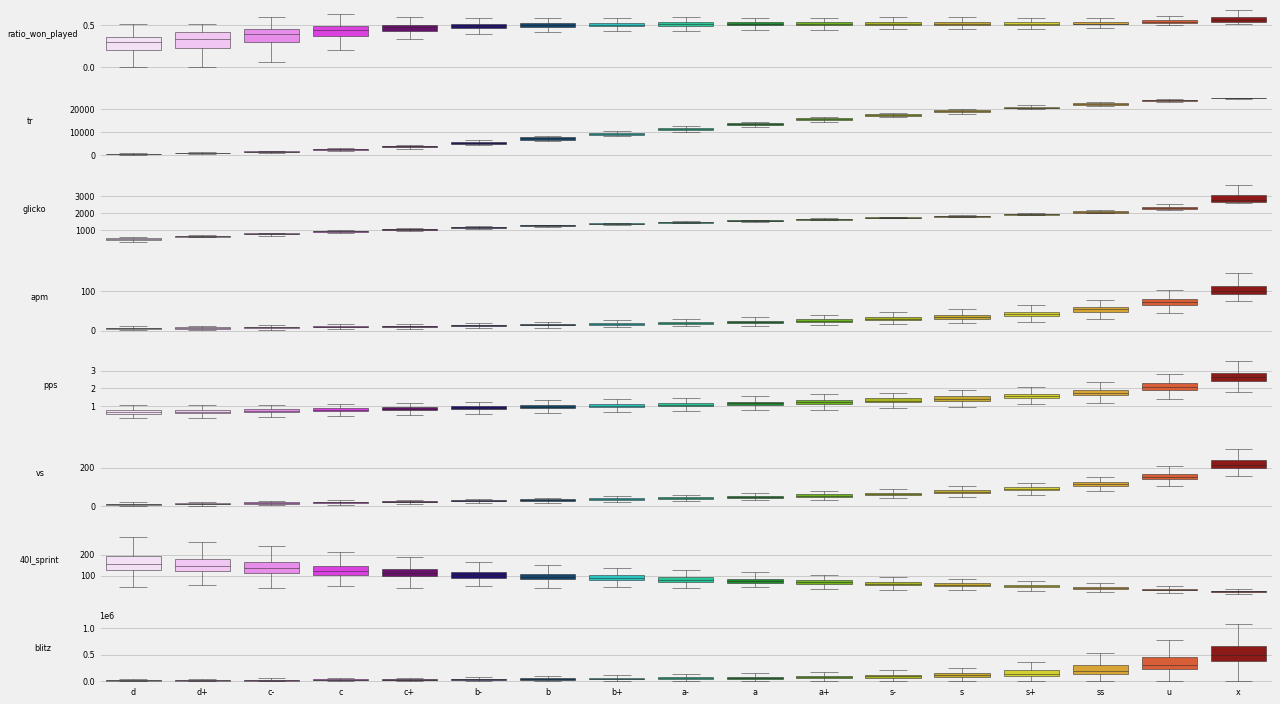

In [6]:
cols = ['ratio_won_played','tr','glicko','apm','pps','vs','40l_sprint','blitz']
fig, ax = plt.subplots(len(cols), 1, figsize=(18,10), sharex=True)
for cnt,c in enumerate(cols):
    sns.boxplot(data=df, x = 'rank', y = c, 
                order=rank_low_to_high, linewidth=0.5, ax=ax[cnt],
                showfliers=False, palette=color_dict)
    if cnt<len(cols):
        ax[cnt].set_xlabel("")
    ax[cnt].xaxis.set_tick_params(labelsize=8)
    ax[cnt].yaxis.set_tick_params(labelsize=8)
    ax[cnt].xaxis.label.set_size(8)
    ax[cnt].set_ylabel(c, rotation=0, fontsize=8, labelpad=40)
    ax[cnt].yaxis.get_offset_text().set_fontsize(8) # change font size of exponant
    plt.tight_layout()
plt.show()

In [7]:
df[cols].corr().style.background_gradient(cmap=cm)

,ratio_won_played,tr,glicko,apm,pps,vs,40l_sprint,blitz
ratio_won_played,1.000000,0.574219,0.633298,0.471236,0.471252,0.476300,-0.514951,0.322497
tr,0.574219,1.000000,0.968156,0.845610,0.841952,0.866892,-0.712632,0.628412
glicko,0.633298,0.968156,1.000000,0.883303,0.868216,0.904732,-0.719202,0.671055
apm,0.471236,0.845610,0.883303,1.000000,0.897032,0.993000,-0.621651,0.816319
pps,0.471252,0.841952,0.868216,0.897032,1.000000,0.901461,-0.685012,0.721243
vs,0.476300,0.866892,0.904732,0.993000,0.901461,1.000000,-0.627906,0.796116
40l_sprint,-0.514951,-0.712632,-0.719202,-0.621651,-0.685012,-0.627906,1.000000,-0.507282
blitz,0.322497,0.628412,0.671055,0.816319,0.721243,0.796116,-0.507282,1.000000


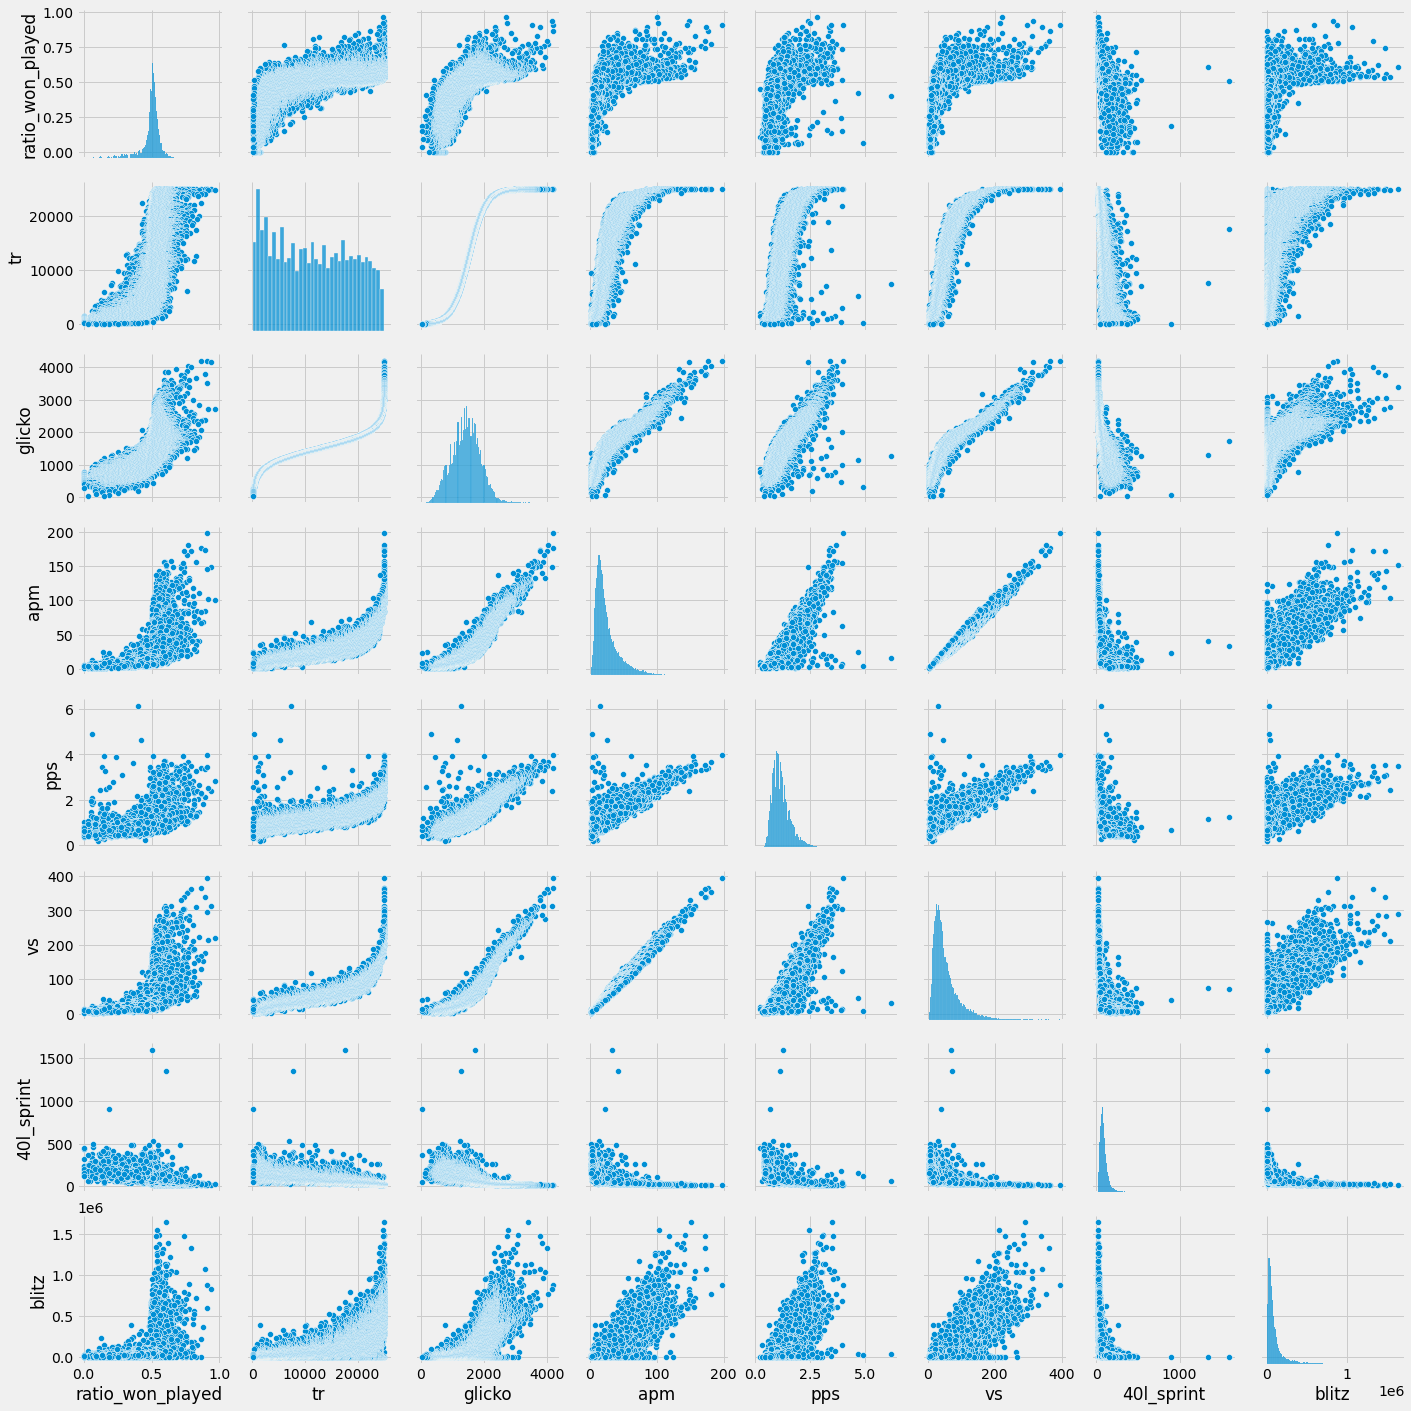

In [8]:
sns.pairplot(df[cols])

Comments:
* as expected the top ranks (`U`,`X`) have higher stats (ratio of game won, ) and lowest response time (`40-line`: the objective is to clear 40 lines as fast as possible)
* there are some high correlated variables that may impact the final results
* for the prediction section, I'll remove the `rank` and the `glicko` features:
    * indeed the Rank is directly derived from the `Tetra Rank` (see picure in introduction) and the `glicko` is derived from the `Rank` as well, as the wiki mentioned: _The rating system is called Tetra Rating, which is based on __Glicko-2__. TR increases for each win and decreases for each loss exclusively. When playing this mode for the first time, the player must play at least 10 ranked matches, referred to as the "rating games", to display their TR. A letter rank is assinged to all players with less than 100 RD (short for Rating Deviation) based on their percentile in the leaderboards. RD normally decreases to a lower limit of 58 RD every time the player plays a TETRA LEAGUE game, and slowly increases at a flat rate of 1 RD per day after a week of inactivity, leading to a maximum of 350 RD._
        * the pairplot also shows a quasi linear correlation between the Rank and Glicko
    * so these 2 features are sources of leakage

<a id="prediction"></a>
# Predictions

The strategy is split the dataset into:
* train: selection of regressors
* validation: used for tuning the selected algorithms
* hold out: final evaluation of individuals and ensemble

In [9]:
df['verified'] = df['verified'].apply(lambda x: 'yes' if x is True else 'no') # convert boolean to categorical
cat_cols = ['verified']
# num_cols = ['ratio_won_played','glicko','apm','pps','vs','40l_sprint','blitz']
num_cols = ['ratio_won_played','apm','pps','vs','40l_sprint','blitz']
X = df[cat_cols + num_cols]
y = df['tr']
print(f"X:{X.shape},y:{y.shape}")

# train/validation/holdout: 70/20/10

X_tmp, X_hold, y_tmp, y_hold = train_test_split(X,y,test_size=0.1, shuffle=True,random_state=1234)

X_train, X_test, y_train, y_test = train_test_split(X_tmp,
                                                    y_tmp,
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=1234)

print(f"all :{X.shape}, train:{X_train.shape}, validation:{X_test.shape}, holdout:{X_hold.shape}")

X:(40790, 7),y:(40790,)
all :(40790, 7), train:(29368, 7), validation:(7343, 7), holdout:(4079, 7)


<a id="based"></a>
## Based regressors: selection of algorithms

* define a pipeline for numerical and categorical features
* note that `X_train` is split later on into 5 folds

In [10]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())]
)

categorical_onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_onehot_transformer, cat_cols),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['ratio_won_played', 'apm', 'pps', 'vs',
                                  '40l_sprint', 'blitz']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['verified'])])

In [11]:
# define regressors to be tested
regressors = {'LinearRegression': LinearRegression(),
              'Ridge' :Ridge(alpha=1),
              'BayesianRidge':BayesianRidge(),
              'RandomForest': RandomForestRegressor(max_depth=6),
              'GradientBoostingRegressor': GradientBoostingRegressor(max_depth=6),
              'KnnRegressor': KNeighborsRegressor(),
              'BaggingRegressor': BaggingRegressor()
       }

In [12]:
random_state = 1234
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1234)

metrics = ['neg_mean_absolute_error','neg_mean_squared_error', 'r2']
regressor_fitted = {}
cross_validate_res = [] # list to hold CV results

for cnt, (clf_name, clf) in enumerate(regressors.items()):
    
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            (clf_name, clf)]
    )
    
#     print(f"processing {clf_name}")
    res = cross_validate(pipe, X_train, y_train, cv=cv, return_train_score=True, scoring=metrics)
    pipe.fit(X_train, y_train)
    regressor_fitted[clf_name] = pipe.predict(X_test)
    res_df = pd.DataFrame(res).mean()
    res_df = pd.DataFrame(res_df).apply(pd.to_numeric).transpose()
    res_df['Regressor'] = clf_name
    cross_validate_res.append(res_df)

In [13]:
# display results of the CV 
pd.concat(cross_validate_res, ignore_index=True).style.background_gradient(cmap=cm)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,Regressor
0,0.043722,0.009366,-2339.628143,-2363.595882,-8592927.659120,-8883675.346665,0.834485,0.830515,LinearRegression
1,0.057343,0.013918,-2339.939500,-2363.983954,-8591179.475471,-8883754.747948,0.834519,0.830514,Ridge
2,0.040731,0.009159,-2339.719184,-2363.709087,-8592401.918048,-8883682.195858,0.834495,0.830515,BayesianRidge
3,3.986357,0.052486,-1134.317656,-1103.299532,-2434580.356948,-2285990.512938,0.953107,0.956388,RandomForest
4,6.295869,0.029334,-1024.886364,-895.709154,-1980182.579374,-1466841.093351,0.961861,0.972015,GradientBoostingRegressor
5,0.115776,0.364147,-1294.737999,-1058.993425,-3184258.001886,-2140465.149604,0.938665,0.959164,KnnRegressor
6,1.760767,0.048029,-1085.323949,-428.165234,-2234552.451286,-397615.585540,0.956961,0.992414,BaggingRegressor


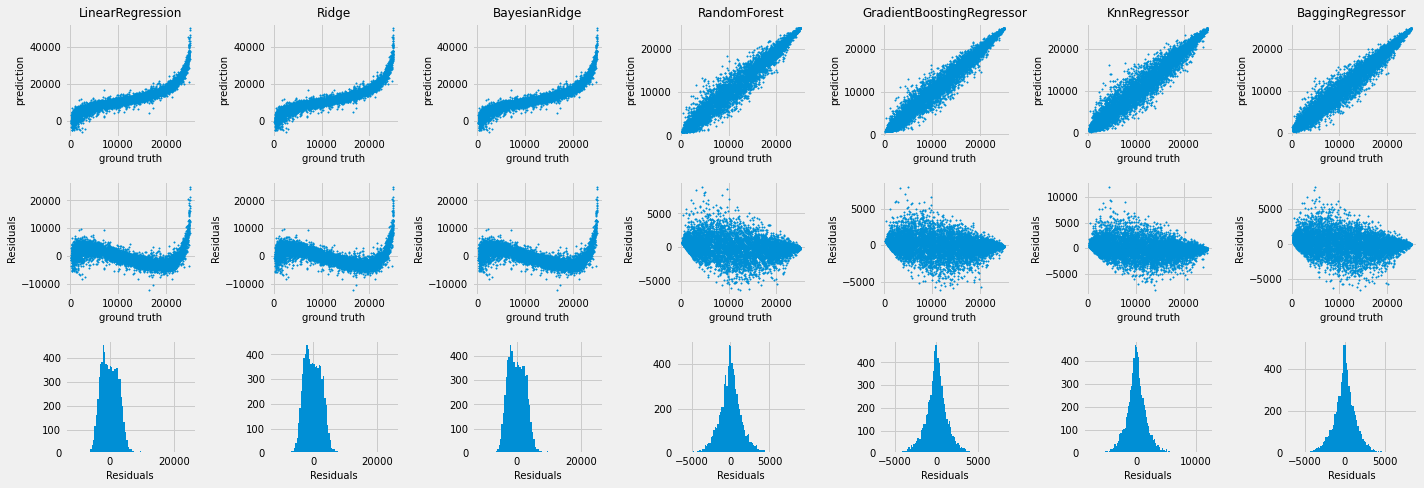

In [14]:
fig, ax = plt.subplots(3,len(regressors), figsize=(20,7))
cnt=0
for k,v in regressor_fitted.items():
    residuals = v - y_test
    ax[0,cnt].scatter(y_test, v, s=2) 
    ax[1,cnt].scatter(y_test, residuals, s=2)
    
    ax[2,cnt].hist(residuals, bins='auto')
    
    ax[0,cnt].set_title(k, fontsize=12)
    ax[0,cnt].set_xlabel('ground truth')
    ax[0,cnt].set_ylabel('prediction')
    ax[1,cnt].set_xlabel('ground truth')
    ax[1,cnt].set_ylabel('Residuals')
    ax[2,cnt].set_xlabel('Residuals')
    
    ax[0,cnt].set_title(k, fontsize=12)
    
    for i in range(0,3):
        ax[i,cnt].xaxis.set_tick_params(labelsize=10)
        ax[i,cnt].yaxis.set_tick_params(labelsize=10)
        ax[i,cnt].xaxis.label.set_size(10)
        ax[i,cnt].yaxis.label.set_size(10)
    
    cnt += 1
plt.tight_layout()
plt.show()

* based on the above results, I will select `RandomForest`, `GradientBoosting` and `Bagging` regressors
* I did try to include `KNN` regressors but got weird results when used alone so I need to investigate this further.

<a id="tuned"></a>
## Tuning : tuned the selected of algorithms

* set the tuning parameters for each of the methods

In [15]:
regressors_selected = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'BaggingRegressor': BaggingRegressor()
}

# list to hold the full individual pipeline for tuning, ie the preprocessor and naked regressor
regressors_to_tuned = []
for clf_name, clf_pipe in regressors_selected.items():
    tmp = {}
    tmp[clf_name] = make_pipeline(preprocessor, clf_pipe)
    regressors_to_tuned.append(tmp)

In [16]:
rf_parameters = {
    'randomforestregressor__max_depth': [2, 6, 12, 16],
    'randomforestregressor__n_estimators': [10, 50, 100, 200],
    'randomforestregressor__max_features': ['sqrt', 'log2', 'auto']
}

gbr_parameters = {
    'gradientboostingregressor__max_depth': [2, 6, 12, 16],
    'gradientboostingregressor__max_features': ['auto', 'sqrt', 'log2'],
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1]
}

knn_parameters = {
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__n_neighbors' :[2,3]
}

bagging_parameters = {
    'baggingregressor__max_samples': [0.2, 0.5, 1.0],
    'baggingregressor__max_features': [0.2, 0.5, 1.0]
}

parameters = [] # list to hold the regressors indicviduals hyper params
parameters.append(rf_parameters)
parameters.append(gbr_parameters)
parameters.append(bagging_parameters)

In [17]:
# tuned each of the pipeline and save the best params models
tuned_models = []

for regressor_pipe, regressor_parameter in zip(regressors_to_tuned, parameters):
#     print(regressor_pipe, regressor_parameter)
    for k, v in regressor_pipe.items():
        # k = name ; v = base pipeline
        print(f"tuning regressor:{k}")
        grid_search = GridSearchCV(v, regressor_parameter, cv=3, return_train_score=True, verbose=0)
        grid_search.fit(X_test, y_test)
        print(f"--> best parameters :{grid_search.best_params_}")
        
        tmp = {}
        tmp[k] = grid_search.best_params_
        tuned_models.append(tmp)

tuning regressor:RandomForest
--> best parameters :{'randomforestregressor__max_depth': 12, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 200}
tuning regressor:GradientBoostingRegressor
--> best parameters :{'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 6, 'gradientboostingregressor__max_features': 'auto'}
tuning regressor:BaggingRegressor
--> best parameters :{'baggingregressor__max_features': 1.0, 'baggingregressor__max_samples': 0.5}


In [18]:
regressors_voting = {
              'RandomForest': RandomForestRegressor(max_depth=12, max_features='auto', n_estimators = 200),
              'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.05, max_depth=6, max_features='auto'),
              'BaggingRegressor': BaggingRegressor(max_features=1.0, max_samples=0.5)
}

regressors_pipeline = []
for cnt, (clf_name, clf) in enumerate(regressors_voting.items()):
    
    current_pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            (clf_name, clf)]
    )
    regressors_pipeline.append({clf_name:current_pipe})

In [19]:
# now run individuals pipeline to compare with the ensemble later on
individuals_score = [] # list to hold the individual score
individuals_pred = {}
estimators = []
for c in regressors_pipeline:
    for k,v in c.items():
        estimators.append((k,v)) # save the current pipeline to be used in the ensemble
        v.fit(X_hold, y_hold)
        individuals_score.append({k:v.score(X_hold, y_hold) })
        individuals_pred[k] = v.predict(X_hold)

In [20]:
individuals_score

[{'RandomForest': 0.9909603673309335},
 {'GradientBoostingRegressor': 0.9810611683317677},
 {'BaggingRegressor': 0.9816301771495366}]

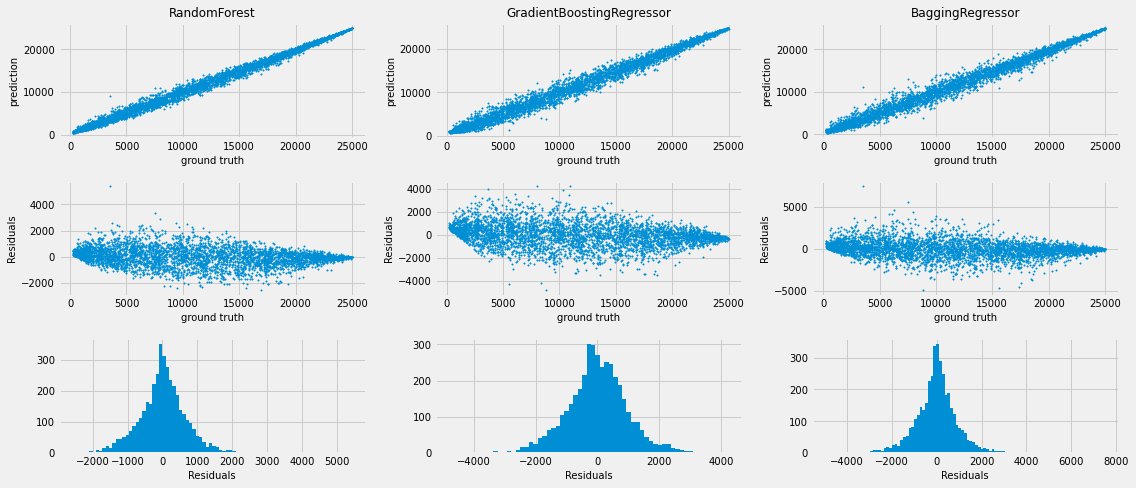

In [21]:
fig, ax = plt.subplots(3,len(individuals_pred), figsize=(16,7))
cnt=0
for k,v in individuals_pred.items():
    # print(k,v)
    residuals = v - y_hold
    ax[0,cnt].scatter(y_hold, v, s=2) 
    ax[1,cnt].scatter(y_hold, residuals, s=2)
    
    ax[2,cnt].hist(residuals, bins='auto')
    
    ax[0,cnt].set_title(k, fontsize=12)
    ax[0,cnt].set_xlabel('ground truth')
    ax[0,cnt].set_ylabel('prediction')
    ax[1,cnt].set_xlabel('ground truth')
    ax[1,cnt].set_ylabel('Residuals')
    ax[2,cnt].set_xlabel('Residuals')
    
    ax[0,cnt].set_title(k, fontsize=12)
    
    for i in range(0,3):
        ax[i,cnt].xaxis.set_tick_params(labelsize=10)
        ax[i,cnt].yaxis.set_tick_params(labelsize=10)
        ax[i,cnt].xaxis.label.set_size(10)
        ax[i,cnt].yaxis.label.set_size(10)
    
    cnt += 1
plt.tight_layout()
plt.show()

* Tuning does actually improved the results for each regressor:
    * residuals are much narrower, same for the `pred` vs. `ground truth` scatter plots

<a id="ensemble"></a>
## Ensemble of tuned regressors

In [22]:
ereg = VotingRegressor(estimators=estimators)
ereg

VotingRegressor(estimators=[('RandomForest',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['ratio_won_played',
                                                                                'apm',
                                                                                'pps',
                                                                                'vs',
                                                                                '40l_sprint',
                                                                                'blitz']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_frequent')),
                                                                                               ('one...
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['ratio_won_played',
                                                                                'apm',
                                                                                'pps',
                                                                                'vs',
                                                                                '40l_sprint',
                                                                                'blitz']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['verified'])])),
                                             ('BaggingRegressor',
                                              BaggingRegressor(max_samples=0.5))]))])

In [23]:
ereg.fit(X_hold, y_hold)
ensemble_score = ereg.score(X_hold, y_hold)

In [24]:
print(f"individuals classifiers scores:{individuals_score}")
print(f"ensemble score:{ensemble_score}")

individuals classifiers scores:[{'RandomForest': 0.9909603673309335}, {'GradientBoostingRegressor': 0.9810611683317677}, {'BaggingRegressor': 0.9816301771495366}]
ensemble score:0.9860814119941694


again a small improvement, but `Random Forest` seems to perform a bit better than the ensemble.

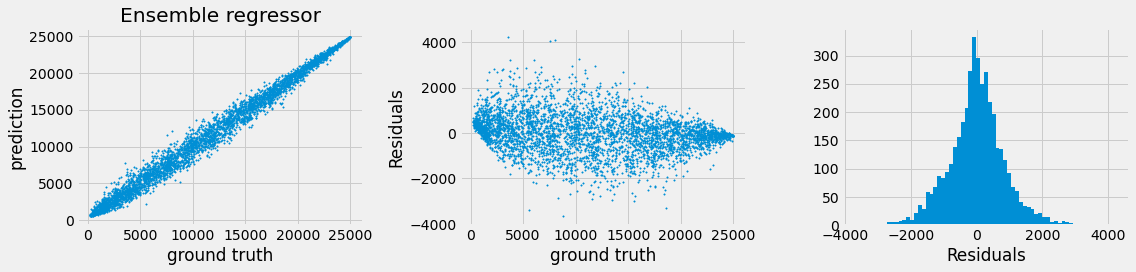

In [25]:
ereg_preds = ereg.predict(X_hold)

fig, ax = plt.subplots(1, 3, figsize=(16,4))
residuals = ereg_preds - y_hold
ax[0].scatter(y_hold, ereg_preds, s=2) 
ax[1].scatter(y_hold, residuals, s=2)

ax[2].hist(residuals, bins='auto')

ax[0].set_title('Ensemble regressor')
ax[0].set_xlabel('ground truth')
ax[0].set_ylabel('prediction')
ax[1].set_xlabel('ground truth')
ax[1].set_ylabel('Residuals')
ax[2].set_xlabel('Residuals')

plt.tight_layout()
plt.show()

In [28]:
y_hold

33817     3141.999128
20932    10942.046756
28727     5919.134505
11010    17287.021491
9766     17962.374071
             ...     
35134     2547.409613
33494     3333.478263
13451    15725.883509
4057     21775.615983
34884     2629.457650
Name: tr, Length: 4079, dtype: float64

In [29]:
v

array([ 3336.46504085, 11160.08668457,  4777.81642389, ...,
       15615.28473911, 22113.24795086,  3268.5015644 ])

In [35]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [33]:
mse(y_hold, v)

965527.7212511908

In [36]:
mae(y_hold, v)

697.7998505893567

In [38]:
mse(y_hold, ereg_preds)

731568.4353463787

In [39]:
mae(y_hold, ereg_preds)

637.6468236063365